## Preprocess and Plot: P2 and P3 Mooring Data from Ross Sea Outflow Experiment (2018-2019)

Data used in this notebook can be accessed [here](https://www.seanoe.org/data/00668/77967/).

Notes: 

This notebook renames variables, constructs individual datasets, and puts time in UTC 

velocity data has already been corrected for magnetic declination 

In [36]:
# import packages 
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import scipy.io as sio
import datetime as datetime
import os
import cmocean as cm
%matplotlib inline
from scipy import stats
import gsw

import sys
sys.path.append('/Users/mblan/Documents/research/TNB_tools/TNB_tools')
import magnetic_declination

## Preprocess Data 
Get data in good netcdf format to work with 

### Mooring P2

In [2]:
# PATH FOR LOCAL MAC USE 
# ds = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/P2_P3_2018/113142.nc')

# PATH FOR DELL USE 
ds = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/P2_P3_2018/113142.nc')

In [3]:
ds.Instrument_01_Time

<xarray.DataArray 'Instrument_01_Time' (SCALAR: 1, AQD_c1802RPB1_14296: 31915)> Size: 255kB
[31915 values with dtype=float64]
Dimensions without coordinates: SCALAR, AQD_c1802RPB1_14296
Attributes:
    long_name:             Time
    unit:                  days since 1950-01-01 00:00:00
    Instrument file name:  c1802RPB1_14296

In [4]:
ds.Instrument_01_Time.values

array([[24886.21875   , 24886.22916667, 24886.23958333, ...,
        25218.63541667, 25218.64583333, 25218.65625   ]], shape=(1, 31915))

In [5]:
# def convert_time(start_time,var,ds):
#     """
#     """
#     base_time = np.datetime64(start_time)

#     nanoseconds_per_day = 86_400_000_000_000

#     time = base_time + (ds[var].values * nanoseconds_per_day).astype("timedelta64[ns]")

#     return time 


In [10]:
import pandas as pd
import numpy as np

def convert_time(start_time, var, ds, round_to="s"):
    """
    Convert 'days since start_time' to datetime64 with clean rounding.
    """
    base_time = pd.Timestamp(start_time)

    td = pd.to_timedelta(ds[var].values, unit="D")

    time = base_time + td

    if round_to is not None:
        time = time.round(round_to)

    return time.to_numpy(dtype="datetime64[ns]")


In [7]:
ds = ds.squeeze()

In [8]:
# select variables from dataset 
# we need to make a nicer xarray dataset 
# There is a total of 6 instruments provided with this dataset 
# I will make one dataset for each instrument and then merge together 

# Dataset 1: AQD_c1802RPB1_14296: 31915

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_01_Time',ds=ds,round_to="s")
time = time.squeeze()

pres = ds['Instrument_01_Press']

temp = ds['Instrument_01_Temp']

speed = ds['Instrument_01_Speed']

u = ds['Instrument_01_u']

v = ds['Instrument_01_v']

dir = ds['Instrument_01_Dir']

pitch = ds['Instrument_01_Pitch']

roll = ds['Instrument_01_Roll']

heading = ds['Instrument_01_Head_i']

amp1 = ds['Instrument_01_Amp1']

amp2 = ds['Instrument_01_Amp2']

amp3 = ds['Instrument_01_Amp3']

w = ds['Instrument_01_W']

In [9]:
# Create new dataset 
# Depth: 1263 m
ds_aqd = xr.Dataset(
    data_vars = dict(
        pres=(['time'], pres.data),
        temp = (['time'], temp.data),
        u = (['time'], u.data),
        v = (['time'],v.data),
        w = (['time'], w.data),
        speed = (['time'], speed.data),
        dir = (['time'],dir.data),
        roll = (['time'], roll.data),
        pitch = (['time'], pitch.data),
        heading = (['time'],heading.data),
        amp1 = (['time'], amp1.data),
        amp2 = (['time'], amp2.data),
        amp3 = (['time'], amp3.data)
    ),
    coords = dict(time=time)
)

# add description of data in attributes 
ds_aqd.attrs['original_description'] = """
P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Nortek Aquadopp Current Meter (AQD),
Instrument Model: aquadop,
Instrument SN: aquadop 14296,
Depth: 1263 m,
Distance from Bottom: 477 m
"""

In [10]:
# Create Dataset 2: SBE37_s1802RP21_16411
# Depth: 1262 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_03_Time', ds=ds, round_to="s")
time = time.squeeze()

ds_sbe1 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds['Instrument_03_Press'].data),
        depth = (['time'], ds['Instrument_03_Depth'].data),
        temp = (['time'], ds['Instrument_03_Temp'].data),
        sal = (['time'], ds['Instrument_03_Sali'].data),
        con = (['time'], ds['Instrument_03_Cond'].data)
    ),
    coords = dict(time=time)
)

# add description of data in attributes
ds_sbe1.attrs['original_description'] = """P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16411,
Depth: 1262 m,
Distance from Bottom: 478 m"""


In [11]:
# Create Dataset 3: SBE37_s1802RP22_16412
# Depth: 1440 m
time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_04_Time', ds=ds,round_to="s")
time = time.squeeze()

ds_sbe2 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds['Instrument_04_Press'].data),
        depth = (['time'], ds['Instrument_04_Depth'].data),
        temp = (['time'], ds['Instrument_04_Temp'].data),
        sal = (['time'], ds['Instrument_04_Sali'].data),
        con = (['time'], ds['Instrument_04_Cond'].data)
    ),
    coords = dict(time=time)
)

# add description of data in attributes
ds_sbe2.attrs['original_description'] = """P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16412,
Depth: 1440 m,
Distance from Bottom: 300 m"""

In [12]:
# Create Dataset 4: SBE37_s1802RP23_16413
# Depth: 1692 m
time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_05_Time', ds=ds, round_to="s")
time = time.squeeze()

ds_sbe3 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds['Instrument_05_Press'].data),
        depth = (['time'], ds['Instrument_05_Depth'].data),
        temp = (['time'], ds['Instrument_05_Temp'].data),
        sal = (['time'], ds['Instrument_05_Sali'].data),
        con = (['time'], ds['Instrument_05_Cond'].data)
    ),
    coords = dict(time=time)
)

# add description of data in attributes
ds_sbe3.attrs['original_description'] = """P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16413,
Depth: 1692 m,
Distance from Bottom: 48 m"""

In [13]:
# Create Dataset 5: Seaguard_c1802RPB1_1110
# Depth: 1720 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_06_Time', ds=ds,round_to="s")
time = time.squeeze()

ds_seaguard = xr.Dataset(
    data_vars = dict(
        tilt = (['time'], ds['Instrument_06_Tilt'].data),
        speed = (['time'], ds['Instrument_06_Speed'].data),
        dir = (['time'], ds['Instrument_06_dir'].data),
    ),
    coords = dict(time=time)
)

# add description of data in attributes
ds_seaguard.attrs['original_description'] = """P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Aanderaa Seagurad,
Instrument Model: seaguard,
Instrument SN: seaguard 1110,
Depth: 1720 m,
Distance from Bottom: 20 m"""

In [14]:
# Create Dataset 6: RBR_t1802RPB1_95518
# Depth: 1563 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_02_Time', ds=ds, round_to="s")
time = time.squeeze()

ds_rbr = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds['Instrument_02_Press'].data),
        temp = (['time'], ds['Instrument_02_Temp'].data),
    ),
    coords = dict(time=time)
)

# add description of data in attributes
ds_rbr.attrs['original_description'] = """P2 Mooring 2018-2019, Ross Sea Outflow Experiment,
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.4601,
Longitude: 172.3024,
Water Depth: 1740 meters,
Start Time: 2018/02/19 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: RBR,
Instrument Model: rbr,
Instrument SN: rbr 95518,
Depth: 1563 m,
Distance from Bottom: 177 m"""

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


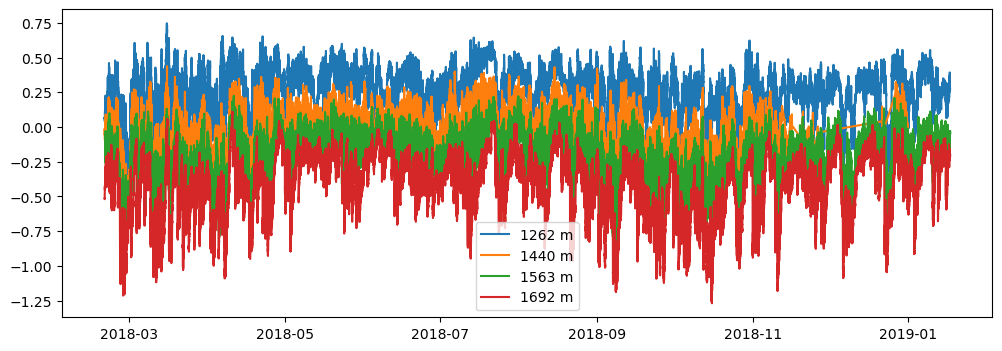

In [15]:
# make some preliminary plots 
fig = plt.figure(figsize=(12,4))

plt.plot(ds_sbe1.time,ds_sbe1.temp, label='1262 m')
plt.plot(ds_sbe2.time,ds_sbe2.temp, label='1440 m')
plt.plot(ds_rbr.time,ds_rbr.temp, label='1563 m')
plt.plot(ds_sbe3.time,ds_sbe3.temp, label='1692 m')
plt.legend()

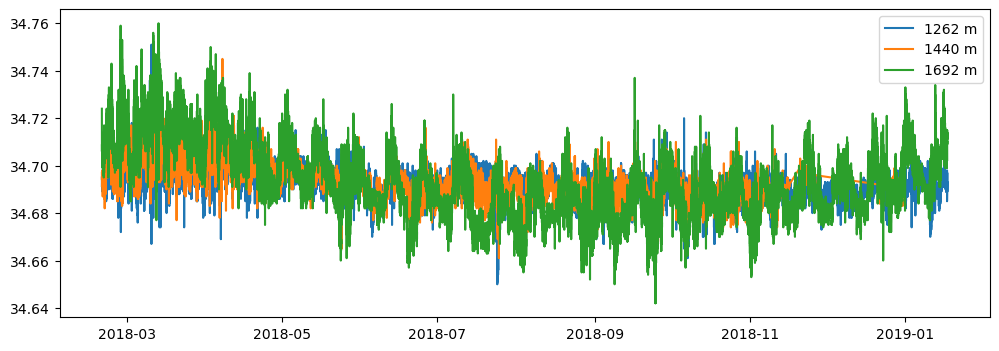

In [16]:
# make some preliminary plots 
fig = plt.figure(figsize=(12,4))

plt.plot(ds_sbe1.time,ds_sbe1.sal, label='1262 m')
plt.plot(ds_sbe2.time,ds_sbe2.sal, label='1440 m')
#plt.plot(ds_rbr.time,ds_rbr.temp, label='1563 m')
plt.plot(ds_sbe3.time,ds_sbe3.sal, label='1692 m')
plt.legend()

Text(0, 0.5, 'Speed, cm/s')

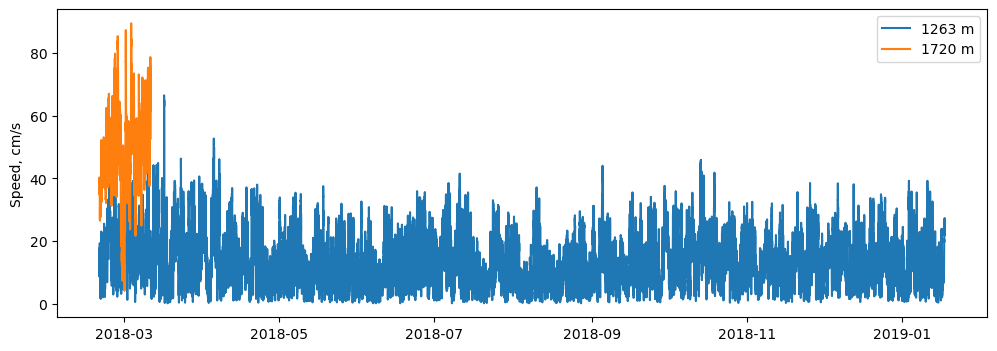

In [17]:
# make some preliminary plots 
fig = plt.figure(figsize=(12,4))

plt.plot(ds_aqd.time,ds_aqd.speed, label='1263 m')
plt.plot(ds_seaguard.time,ds_seaguard.speed, label='1720 m')
#plt.plot(ds_rbr.time,ds_rbr.temp, label='1563 m')
#plt.plot(ds_sbe3.time,ds_sbe3.sal, label='1692 m')
plt.legend()
plt.ylabel('Speed, cm/s')

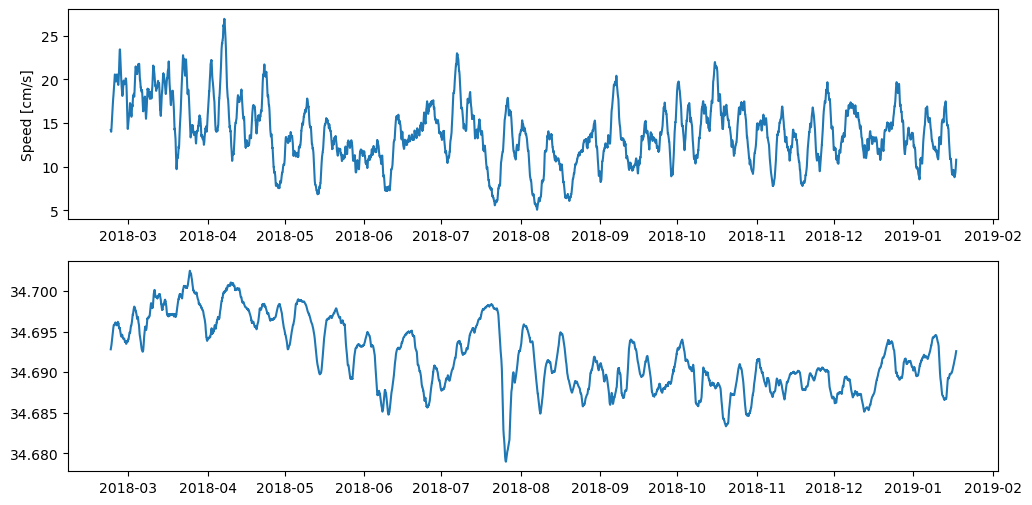

In [18]:
fig = plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(ds_aqd.rolling(time=288).mean().time,ds_aqd.rolling(time=288).mean().speed, label='1263 m')
plt.ylabel('Speed [cm/s]')

plt.subplot(2,1,2)
plt.plot(ds_sbe1.rolling(time=864).mean().time,ds_sbe1.rolling(time=864).mean().sal, label='1262 m')

In [19]:
P2_2018_temp_mid_1563 = ds_rbr.assign_coords(z=1563,lat=-71.4601,lon=172.3024)
P2_2018_speed_bot_1720 = ds_seaguard.assign_coords(z=1720,lat=-71.4601,lon=172.3024)
P2_2018_vel_top_1263 = ds_aqd.assign_coords(z=1263,lat=-71.4601,lon=172.3024)
P2_2018_ctd_top_1262 = ds_sbe1.assign_coords(z=1262,lat=-71.4601,lon=172.3024)
P2_2018_ctd_mid_1440 = ds_sbe2.assign_coords(z=1440,lat=-71.4601,lon=172.3024)
P2_2018_ctd_bot_1692 = ds_sbe3.assign_coords(z=1692,lat=-71.4601,lon=172.3024)

In [20]:
# calculate other relevant variables for CTD sensors 
ds_list = [P2_2018_ctd_top_1262,P2_2018_ctd_mid_1440,P2_2018_ctd_bot_1692]

for ds in ds_list:
    ds['abs_sal'] = gsw.SA_from_SP(ds.sal,ds.pres,172.3024,-71.4601)
    ds['cons_temp'] = gsw.CT_from_t(ds['abs_sal'],ds.temp,ds.pres)
    ds['theta'] = gsw.pt_from_t(ds['abs_sal'],ds.temp,ds.pres,0)
    ds['sigma0'] = gsw.sigma0(ds['abs_sal'],ds['cons_temp'])

In [21]:
# define attributes to add to each dataset 
# define matadata for coorindates and variables - this will be the same for top and bottom sensor 
P2_META_CTD = {
    "pres": {
        "long_name": "Pressure",
        "units": "dbar",
    },
    "sal": {
        "long_name": "Practical salinity",
        "units": "PSU",
    },
    "temp": {
        "long_name": "Temperature [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "con": {
        "long_name": "Conductivity",
        "units": "S/m",
    },
    "z": {
        "long_name": "Depth",
        "units": "m",
        "description": "Depth is positive downward"
    },
    "lat": {
        "long_name": "Latitude",
        "units": "degrees_north",
    },
    "lon": {
        "long_name": "Longitude",
        "units": "degrees_east",
    },
        "abs_sal": {
        "long_name": "Absolute Salinity",
        "units": "g/kg",
    },
    "cons_temp": {
        "long_name": "Conservative Temperature",
        "units": "degree_Celsius",
    },
    "sigma0": {
        "long_name": "Potential Density Anomaly",
        "units": "kg/m3",
    },
    "theta": {
        "long_name": "Potential Temperature",
        "units": "degree_Celsius",
    },
}

In [22]:
for v, attrs in P2_META_CTD.items():
    if v in P2_2018_ctd_top_1262:
        P2_2018_ctd_top_1262[v].attrs.update(attrs)

        # same meta data for tnbd bot so we can apply to that dataset as well.
for v, attrs in P2_META_CTD.items():
    if v in P2_2018_ctd_mid_1440:
        P2_2018_ctd_mid_1440[v].attrs.update(attrs)

for v, attrs in P2_META_CTD.items():
    if v in P2_2018_ctd_bot_1692:
        P2_2018_ctd_bot_1692[v].attrs.update(attrs)

for v, attrs in P2_META_CTD.items():
    if v in P2_2018_temp_mid_1563:
        P2_2018_temp_mid_1563[v].attrs.update(attrs)

In [23]:
P2_2018_vel_top_1263

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 31915)
Coordinates:
  * time     (time) datetime64[ns] 255kB 2018-02-19T05:15:00 ... 2019-01-17T1...
    z        int64 8B 1263
    lat      float64 8B -71.46
    lon      float64 8B 172.3
Data variables: (12/13)
    pres     (time) float64 255kB 1.277e+03 1.277e+03 ... 1.28e+03 1.28e+03
    temp     (time) float64 255kB 0.22 0.12 0.09 0.08 ... 0.3 0.28 0.29 0.29
    u        (time) float64 255kB 14.28 17.08 15.68 ... -8.936 -12.27 -11.08
    v        (time) float64 255kB -10.29 0.7399 3.657 ... 19.88 18.86 20.72
    w        (time) float64 255kB -0.046 -0.041 -0.044 ... -0.045 -0.052 -0.038
    speed    (time) float64 255kB 17.6 17.1 16.1 12.7 ... 22.4 21.8 22.5 23.5
    ...       ...
    roll     (time) float64 255kB 0.3 0.0 -0.1 0.0 0.2 ... 2.0 1.0 0.4 2.2 1.6
    pitch    (time) float64 255kB -0.8 -1.0 -1.1 -1.0 ... -1.8 -2.3 -1.3 -1.8
    heading  (time) float64 255kB 106.6 72.3 54.7 60.2 ... 314.0 293.8 290.4
    amp1     (time) float64 255kB 77.0 78.0 78.0 79.0 ... 68.0 73.0 70.0 70.0
    amp2     (time) float64 255kB 81.0 80.0 80.0 79.0 ... 68.0 66.0 70.0 70.0
    amp3     (time) float64 255kB 79.0 80.0 81.0 79.0 ... 71.0 72.0 73.0 70.0
Attributes:
    original_description:  \nP2 Mooring 2018-2019, Ross Sea Outflow Experimen...

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Text(0.5, 1.0, 'Deep (1087 m)')

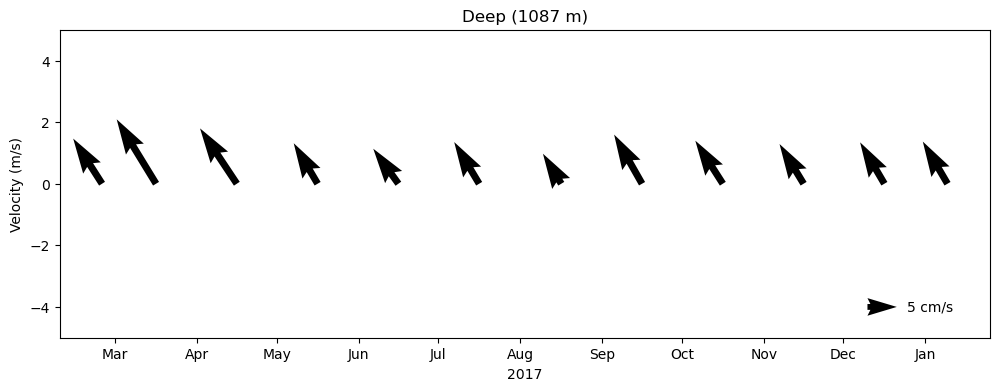

In [24]:
# investigate P2 velocity direction to decide whether its already been corrected for magnetic declination 
# at this location I would expect a westward current 
ds = P2_2018_vel_top_1263
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,4))
q = plt.quiver(
    ds.time.resample(time='1M').mean().values,np.zeros_like(ds.time.resample(time='1M').mean().values, dtype=float),
    ds.u.resample(time='1M').mean(),
    ds.v.resample(time='1M').mean()
)
plt.quiverkey(q, X=0.90, Y=0.1, U=5, label='5 cm/s', labelpos='E')

plt.ylabel('Velocity (m/s)')
plt.ylim(-5,5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Show year once at the left
ax.set_xlabel('2017')
ax.set_title('Deep (1087 m)')

This direction looks reasonable. I am not going to correct for magnetic declination because I think it has already been done. 

In [25]:
# # input magnetic declination 
# P2_2018_vel_top_1263 = P2_2018_vel_top_1263.assign_coords(mag_declination = 101.48)
# P2_2018_speed_bot_1720 = P2_2018_speed_bot_1720.assign_coords(mag_declination = 101.48)

In [26]:
# attributes for velocity data 
P2_META_vel = {
    "pres": {
        "long_name": "Pressure",
        "units": "dbar",
    },
    "temp": {
        "long_name": "Temperature [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "z": {
        "long_name": "Depth",
        "units": "m",
        "description": "Depth is positive downward"
    },
    "lat": {
        "long_name": "Latitude",
        "units": "degrees_north",
    },
    "lon": {
        "long_name": "Longitude",
        "units": "degrees_east",
    },
    "u": {
        "long_name": "Eastward Velocity",
        "units": "cm/s",
    },
    "v": {
        "long_name": "Northward Velocity",
        "units": "cm/s",
    },
    "w": {
        "long_name": "Vertical Velocity",
        "units": "m/s",
    },
    "speed": {
        "long_name": "Current Speed",
        "units": "cm/s",
    },
    "dir": {
        "long_name": "Current Direction",
        "units": "degrees",
        "description": "Direction toward which the current is flowing, clockwise from true North"
    },
    "mag_declination": {
        "long_name": "Magnetic Declination",
        "units": "degrees East",
        "description": "Angle between magnetic North and true North"
    },
}

In [27]:
# add attributes to velocity dataset
for v, attrs in P2_META_vel.items():
    if v in P2_2018_vel_top_1263:
        P2_2018_vel_top_1263[v].attrs.update(attrs)

for v, attrs in P2_META_vel.items():
    if v in P2_2018_speed_bot_1720:
        P2_2018_speed_bot_1720[v].attrs.update(attrs)

In [28]:
# need to fix time in all datasets - put in UTC 
ds_list = [P2_2018_vel_top_1263,
           P2_2018_temp_mid_1563,
           P2_2018_ctd_bot_1692,
           P2_2018_ctd_mid_1440,
           P2_2018_speed_bot_1720,
           P2_2018_ctd_top_1262]

for ds in ds_list:
    ds['time'] = ds['time'] - pd.Timedelta('12hr')

In [29]:
# import sys
# sys.path.append('/Users/mblan/Documents/research/TNB_tools/TNB_tools')
# import magnetic_declination

In [30]:
# magnetic_declination_radians = np.deg2rad(P2_2018_vel_top_1263.mag_declination)
# u_prime, v_prime = magnetic_declination.rotate_velocity(P2_2018_vel_top_1263.u,P2_2018_vel_top_1263.v,-magnetic_declination_radians)
# new_dir = magnetic_declination.calculate_direction(u_prime,v_prime)

In [31]:
# replace in dataset 
# P2_2018_vel_top_1263['u'] = ('time', u_prime.data)
# P2_2018_vel_top_1263['v'] = ('time', v_prime.data)
# P2_2018_vel_top_1263['dir'] = ('time', new_dir.data)

In [32]:
# # calcualte true direction for seaguard data 
# direction = magnetic_declination.calculate_true_direction(P2_2018_speed_bot_1720.dir,P2_2018_speed_bot_1720.mag_declination)

In [33]:
# # repeat for speed dataset - DO THIS LATER 
# P2_2018_speed_bot_1720['dir'] = ('time', direction.data)

In [34]:
P2_2018_vel_top_1263

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 31915)
Coordinates:
  * time     (time) datetime64[ns] 255kB 2018-02-18T17:15:00 ... 2019-01-17T0...
    z        int64 8B 1263
    lat      float64 8B -71.46
    lon      float64 8B 172.3
Data variables: (12/13)
    pres     (time) float64 255kB 1.277e+03 1.277e+03 ... 1.28e+03 1.28e+03
    temp     (time) float64 255kB 0.22 0.12 0.09 0.08 ... 0.3 0.28 0.29 0.29
    u        (time) float64 255kB 14.28 17.08 15.68 ... -8.936 -12.27 -11.08
    v        (time) float64 255kB -10.29 0.7399 3.657 ... 19.88 18.86 20.72
    w        (time) float64 255kB -0.046 -0.041 -0.044 ... -0.045 -0.052 -0.038
    speed    (time) float64 255kB 17.6 17.1 16.1 12.7 ... 22.4 21.8 22.5 23.5
    ...       ...
    roll     (time) float64 255kB 0.3 0.0 -0.1 0.0 0.2 ... 2.0 1.0 0.4 2.2 1.6
    pitch    (time) float64 255kB -0.8 -1.0 -1.1 -1.0 ... -1.8 -2.3 -1.3 -1.8
    heading  (time) float64 255kB 106.6 72.3 54.7 60.2 ... 314.0 293.8 290.4
    amp1     (time) float64 255kB 77.0 78.0 78.0 79.0 ... 68.0 73.0 70.0 70.0
    amp2     (time) float64 255kB 81.0 80.0 80.0 79.0 ... 68.0 66.0 70.0 70.0
    amp3     (time) float64 255kB 79.0 80.0 81.0 79.0 ... 71.0 72.0 73.0 70.0
Attributes:
    original_description:  \nP2 Mooring 2018-2019, Ross Sea Outflow Experimen...

In [35]:
# add in description of what preprocessing I've done so far / info on where the data came from: 

final_datasets = [P2_2018_vel_top_1263, P2_2018_temp_mid_1563, P2_2018_ctd_bot_1692, P2_2018_ctd_mid_1440, P2_2018_ctd_top_1262,
                  P2_2018_speed_bot_1720]

for i in range(len(final_datasets)):
    final_datasets[i].attrs['description'] = """ 
        Accessed from: https://www.seanoe.org/data/00668/77967/,
        Time: Converted to UTC (subtracted 12 hrs)
        Preprocessing: Added lat, lon, and depth coordinates; renamed variables
"""

In [37]:
P2_2018_vel_top_1263

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 31915)
Coordinates:
  * time     (time) datetime64[ns] 255kB 2018-02-18T17:15:00 ... 2019-01-17T0...
    z        int64 8B 1263
    lat      float64 8B -71.46
    lon      float64 8B 172.3
Data variables: (12/13)
    pres     (time) float64 255kB 1.277e+03 1.277e+03 ... 1.28e+03 1.28e+03
    temp     (time) float64 255kB 0.22 0.12 0.09 0.08 ... 0.3 0.28 0.29 0.29
    u        (time) float64 255kB 14.28 17.08 15.68 ... -8.936 -12.27 -11.08
    v        (time) float64 255kB -10.29 0.7399 3.657 ... 19.88 18.86 20.72
    w        (time) float64 255kB -0.046 -0.041 -0.044 ... -0.045 -0.052 -0.038
    speed    (time) float64 255kB 17.6 17.1 16.1 12.7 ... 22.4 21.8 22.5 23.5
    ...       ...
    roll     (time) float64 255kB 0.3 0.0 -0.1 0.0 0.2 ... 2.0 1.0 0.4 2.2 1.6
    pitch    (time) float64 255kB -0.8 -1.0 -1.1 -1.0 ... -1.8 -2.3 -1.3 -1.8
    heading  (time) float64 255kB 106.6 72.3 54.7 60.2 ... 314.0 293.8 290.4
    amp1     (time) float64 255kB 77.0 78.0 78.0 79.0 ... 68.0 73.0 70.0 70.0
    amp2     (time) float64 255kB 81.0 80.0 80.0 79.0 ... 68.0 66.0 70.0 70.0
    amp3     (time) float64 255kB 79.0 80.0 81.0 79.0 ... 71.0 72.0 73.0 70.0
Attributes:
    original_description:  \nP2 Mooring 2018-2019, Ross Sea Outflow Experimen...
    description:            \n        Accessed from: https://www.seanoe.org/d...

In [38]:
# save finalized datasets

final_datasets = [P2_2018_vel_top_1263, P2_2018_temp_mid_1563, P2_2018_ctd_bot_1692, P2_2018_ctd_mid_1440, P2_2018_ctd_top_1262,
                  P2_2018_speed_bot_1720]

final_names = ['P2_2018_vel_top_1263', 'P2_2018_temp_mid_1563', 'P2_2018_ctd_bot_1692', 'P2_2018_ctd_mid_1440', 'P2_2018_ctd_top_1262',
                  'P2_2018_speed_bot_1720']

for i in range(len(final_datasets)):
    final_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/RossSeaOutflow/P2/'+final_names[i]+'.nc')

### TO-DO: 

- need to verify magnetic declination correction was not already imposed on data available online 
- need to update attributes based on what I did for preprocessing 

In [ ]:
# # list of final datasets to save 
# final_datasets = [ds_aqd, ds_sbe1, ds_sbe2, ds_sbe3, ds_seaguard, ds_rbr]
# # list of name strings for each dataset to loop through when saving - format: 'mooringname_year_instrument_depth'
# final_names = ['P2_2018_aqd_1263', 'P2_2018_sbe_1262', 'P2_2018_sbe_1440', 'P2_2018_sbe_1692', 'P2_2018_seaguard_1720', 'P2_2018_rbr_1563']
# # loop through and save each dataset as a netcdf file
# for i in range(len(final_datasets)):
#     final_datasets[i].to_netcdf(path='/Users/mblan/Documents/research/data/mooring/P2/'+final_names[i]+'.nc')

### Questions about data: 

1. is vertical velocity in m/s? 
2. Has any correction for magnetic declination already been applied?

TO-DO:

- need to write a function for correcting direction for magnetic declination on instruments like seaguards that only provide speed and direction 

### Mooring P3

In [6]:
# Path for Local work on MAC 
#ds1 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/P2_P3_2018/113143.nc')

# Path for DELL 
# ds1 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/P2_P3_2018/113143.nc')

# NEW DATASET SENT FROM MELISSA BOWEN ON 01/28/2026 - HAS CORRECTED SALINITY AT BOTTOM SENSOR AND INSTRUMENT 6 REMOVED BECAUSE DATA NO GOOD 
# MAGNETIC DECLINATION HAS BEEN CORRECTED FOR ON DIRECTION DATA - NEED TO VERFIY IF ALSO APPLIED TO COMPONENETS 
ds1 = xr.open_dataset('//thepenguin/penguin2/Data/TNB/mooring/RossSeaOutflow/P3/raw/P3_2018_2019.nc')

In [7]:
ds1 = ds1.squeeze()

In [8]:
ds1

<xarray.Dataset> Size: 19MB
Dimensions:               (AQD_c1802RPC1_14295: 31831, c1802RPC1_14295: 31831,
                           SBE37_s1802RPC1_16417: 95487,
                           SBE37_s1802RPC2_16418: 95487,
                           SBE37_s1802RPC3_16419: 95487,
                           SBE56_t1802RPC1_2086: 222833)
Dimensions without coordinates: AQD_c1802RPC1_14295, c1802RPC1_14295,
                                SBE37_s1802RPC1_16417, SBE37_s1802RPC2_16418,
                                SBE37_s1802RPC3_16419, SBE56_t1802RPC1_2086
Data variables: (12/33)
    lat                   float64 8B ...
    lon                   float64 8B ...
    Instrument_01_Time    (AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Press   (AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Temp    (AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Speed   (AQD_c1802RPC1_14295) float64 255kB ...
    ...                    ...
    Instrument_04_Press   (SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Temp    (SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Sali    (SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Cond    (SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_05_Time    (SBE56_t1802RPC1_2086) float64 2MB ...
    Instrument_05_Temp    (SBE56_t1802RPC1_2086) float64 2MB ...
Attributes:
    Title:          P3 Mooring 2018-2019, Ross Sea Outflow Experiment
    Contact:        Melissa Bowen, m.bowen@auckland.ac.nz
    Creation Time:  24-Jan-2026
    Description:    Location: Ross Sea\nProject Leader: Melissa Bowen\nLatitu...
    Instrument_01:  Instrument Type: Nortek Aquadopp Current Meter (AQD)\nIns...
    Instrument_02:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_03:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_04:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_05:  Instrument Type: Seabird SBE-56\nInstrument Model: sbe56\...
    Instrument_06:  Instrument Type: Aanderaa SeaGuard\nInstrument Model: sea...

In [11]:
# Dataset 1: AQD_c1802RPC1_14295

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_01_Time',ds=ds1,round_to='s')
time = time.squeeze()

pres = ds1['Instrument_01_Press']

temp = ds1['Instrument_01_Temp']

speed = ds1['Instrument_01_Speed']

u = ds1['Instrument_01_u']

v = ds1['Instrument_01_v']

dir = ds1['Instrument_01_Dir']

pitch = ds1['Instrument_01_Pitch']

roll = ds1['Instrument_01_Roll']

heading = ds1['Instrument_01_Head_i']

amp1 = ds1['Instrument_01_Amp1']

amp2 = ds1['Instrument_01_Amp2']

amp3 = ds1['Instrument_01_Amp3']

w = ds1['Instrument_01_W']

In [12]:
# Create new dataset 
# Depth: 1263 m
ds_aqd_P3 = xr.Dataset(
    data_vars = dict(
        pres=(['time'], pres.data),
        temp = (['time'], temp.data),
        u = (['time'], u.data),
        v = (['time'],v.data),
        w = (['time'], w.data),
        speed = (['time'], speed.data),
        dir = (['time'],dir.data),
        roll = (['time'], roll.data),
        pitch = (['time'], pitch.data),
        heading = (['time'],heading.data),
        amp1 = (['time'], amp1.data),
        amp2 = (['time'], amp2.data),
        amp3 = (['time'], amp3.data)
    ),
    coords = dict(time=time)
)

# add in description of data in attributes 
ds_aqd_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.9181,
Longitude: 172.9265,
Water Depth: 1715 meters,
Start Time: 2018/02/20 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Nortek Aquadopp Current Meter (AQD),
Instrument Model: aquadop,
Instrument SN: aquadop 14295,
Depth: 1263 m"""

In [13]:
# Create Dataset 2: SBE37_s1802RPC1_16417
# Depth: 1262 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_02_Time', ds=ds1, round_to='s')
time = time.squeeze()

ds_sbe1_P3 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds1['Instrument_02_Press'].data),
        temp = (['time'], ds1['Instrument_02_Temp'].data),
        sal = (['time'], ds1['Instrument_02_Sali'].data),
        con = (['time'], ds1['Instrument_02_Cond'].data)
    ),
    coords = dict(time=time)
)

# add in description of data in attributes
ds_sbe1_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.9181,
Longitude: 172.9265,
Water Depth: 1715 meters,
Start Time: 2018/02/20 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16417,
Depth: 1262 m"""

In [14]:
# Create Dataset 2: SBE37_s1802RPC2_16418
# Depth: 1414 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_03_Time', ds=ds1, round_to='s')
time = time.squeeze()

ds_sbe2_P3 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds1['Instrument_03_Press'].data),
        temp = (['time'], ds1['Instrument_03_Temp'].data),
        sal = (['time'], ds1['Instrument_03_Sali'].data),
        con = (['time'], ds1['Instrument_03_Cond'].data)
    ),
    coords = dict(time=time)
)

# add in description of data in attributes
ds_sbe2_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.9181,
Longitude: 172.9265,
Water Depth: 1715 meters,
Start Time: 2018/02/20 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16418,
Depth: 1414 m"""

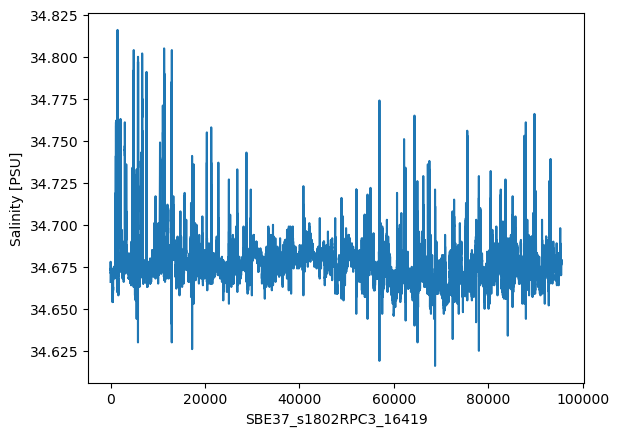

In [15]:
fig = plt.figure()
ds1['Instrument_04_Sali'].plot()

In [16]:
# Create Dataset 2: SBE37_s1802RPC3_16419
# Depth: 1667 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_04_Time', ds=ds1, round_to='s')
time = time.squeeze()

ds_sbe3_P3 = xr.Dataset(
    data_vars = dict(
        pres = (['time'], ds1['Instrument_04_Press'].data),
        temp = (['time'], ds1['Instrument_04_Temp'].data),
        sal = (['time'], ds1['Instrument_04_Sali'].data),
        con = (['time'], ds1['Instrument_04_Cond'].data)
    ),
    coords = dict(time=time)
)

# add in description of data in attributes
ds_sbe3_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.9181,
Longitude: 172.9265,
Water Depth: 1715 meters,
Start Time: 2018/02/20 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-37,
Instrument Model: mcat,
Instrument SN: mcat 16419,
Depth: 1667 m"""


In [17]:
# Create Dataset 2: SBE56_t1802RPC1_2086
# Depth: Depth: 1498 m

time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_05_Time', ds=ds1, round_to='s')
time = time.squeeze()

ds_sbe4_P3 = xr.Dataset(
    data_vars = dict(
        temp = (['time'], ds1['Instrument_05_Temp'].data),
    ),
    coords = dict(time=time)
)

# add in description of data in attributes
ds_sbe4_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
Location: Ross Sea,
Project Leader: Melissa Bowen,
Latitude: -71.9181,
Longitude: 172.9265,
Water Depth: 1715 meters,
Start Time: 2018/02/20 UTC+12,
End Time: 2019/01/17 UTC+12,
Instrument Type: Seabird SBE-56,
Instrument Model: sbe56,
Instrument SN: sbe56 2086,
Depth: 1498 m"""


In [19]:
# # Create Dataset 5: Seagurad_c1802RPB1_1110
# # Depth: 1693 m

# time = convert_time(start_time="1950-01-01T00:00:00",var='Instrument_06_Time',ds=ds1, round_to='s')
# time = time.squeeze()

# ds_seaguard_P3 = xr.Dataset(
#     data_vars = dict(
#         tilt = (['time'], ds1['Instrument_06_Tilt'].data),
#         speed = (['time'], ds1['Instrument_06_Speed'].data),
#         dir = (['time'], ds1['Instrument_06_dir'].data),
#     ),
#     coords = dict(time=time)
# )

# # add in description of data in attributes
# ds_seaguard_P3.attrs['original Description'] = """P3 Mooring 2018-2019, Ross Sea Outflow Experiment, 
# Location: Ross Sea,
# Project Leader: Melissa Bowen,
# Latitude: -71.9181,
# Longitude: 172.9265,
# Water Depth: 1715 meters,
# Start Time: 2018/02/20 UTC+12,
# End Time: 2019/01/17 UTC+12,
# Instrument Type: Aanderaa Seagurad,
# Instrument Model: seaguard,
# Instrument SN: seaguard 1111,
# Depth: 1693 m,
# Distance from Bottom: 22 m"""

(34.6, 34.8)

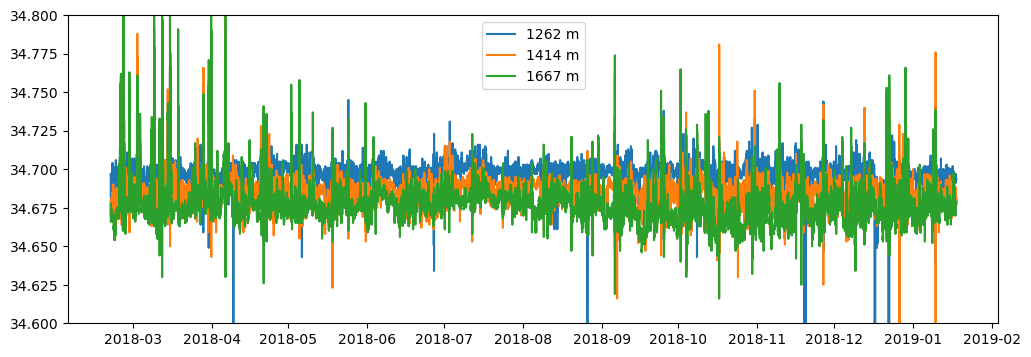

In [23]:
# make some preliminary plots 
fig = plt.figure(figsize=(12,4))

plt.plot(ds_sbe1_P3.time,ds_sbe1_P3.sal, label='1262 m')
plt.plot(ds_sbe2_P3.time,ds_sbe2_P3.sal, label='1414 m')
plt.plot(ds_sbe3_P3.time,ds_sbe3_P3.sal, label='1667 m')
# plt.plot(ds_sbe4_P3.time,ds_sbe4_P3.sal, label='1498 m')
plt.legend()
plt.ylim(34.6,34.8)

In [25]:
P3_2018_vel_top_1263 = ds_aqd_P3.assign_coords(z=1263,lat=-71.9181,lon=172.9265)
P3_2018_ctd_top_1262 = ds_sbe1_P3.assign_coords(z=1262,lat=-71.9181,lon=172.9265)
P3_2018_ctd_mid_1414 = ds_sbe2_P3.assign_coords(z=1414,lat=-71.9181,lon=172.9265)
P3_2018_temp_mid_1498 = ds_sbe4_P3.assign_coords(z=1498,lat=-71.9181,lon=172.9265)
P3_2018_ctd_bot_1667 = ds_sbe3_P3.assign_coords(z=1667,lat=-71.9181,lon=172.9265)
# P3_2018_speed_bot_1693 = ds_seaguard_P3.assign_coords(z=1693,lat=-71.9181,lon=172.9265)

In [26]:
# fix time - need to subtract 12 hours for time to be in UTC 
P3_2018_vel_top_1263['time'] = P3_2018_vel_top_1263.time - pd.Timedelta('12hr')
P3_2018_temp_mid_1498['time'] = P3_2018_temp_mid_1498.time - pd.Timedelta('12hr')
P3_2018_ctd_top_1262['time'] = P3_2018_ctd_top_1262.time - pd.Timedelta('12hr')
P3_2018_ctd_mid_1414['time'] = P3_2018_ctd_mid_1414.time - pd.Timedelta('12hr')
P3_2018_ctd_bot_1667['time'] = P3_2018_ctd_bot_1667.time - pd.Timedelta('12hr')
# P3_2018_speed_bot_1693['time'] = P3_2018_speed_bot_1693.time - pd.Timedelta('12hr')

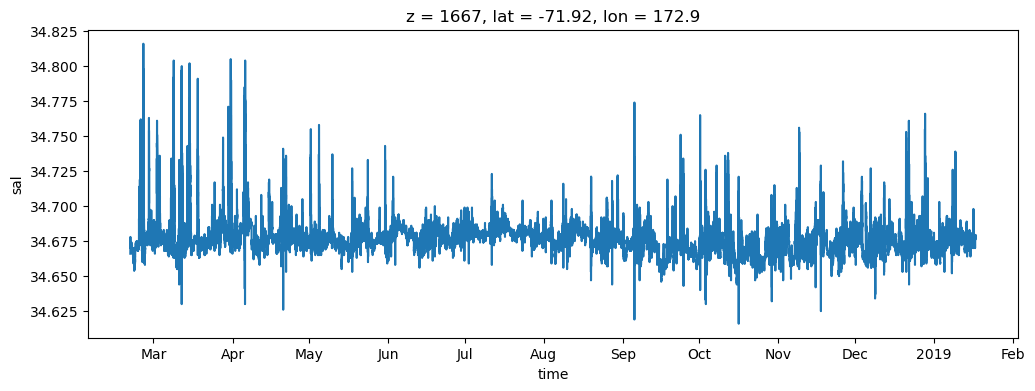

In [27]:
# NEED TO ASK MELISSA ABOUT THIS SALINITY DATA IN PARTICULAR - i THINK TEMP DATA GOT INSERTED BY MISTAKE 
fig = plt.figure(figsize=(12,4))
P3_2018_ctd_bot_1667.sal.plot()

In [28]:
# calculate other relevant variables for CTD sensors 
ds_list = [P3_2018_ctd_bot_1667, P3_2018_ctd_mid_1414, P3_2018_ctd_top_1262]

for ds in ds_list:
    ds['abs_sal'] = gsw.SA_from_SP(ds.sal,ds.pres,172.9,-71.92)
    ds['cons_temp'] = gsw.CT_from_t(ds['abs_sal'],ds.temp,ds.pres)
    ds['theta'] = gsw.pt_from_t(ds['abs_sal'],ds.temp,ds.pres,0)
    ds['sigma0'] = gsw.sigma0(ds['abs_sal'],ds['cons_temp'])

In [29]:
# input magnetic declination 
# P3_2018_vel_top_1263 = P3_2018_vel_top_1263.assign_coords(mag_declination = 103.67)
# P3_2018_speed_bot_1693 = P3_2018_speed_bot_1693.assign_coords(mag_declination = 103.67)

In [30]:
# define matadata for coorindates and variables - this will be the same for top and bottom sensor 
META_DATA = {
    "pres": {
        "long_name": "Pressure",
        "units": "dbar",
    },
    "abs_sal": {
        "long_name": "Absolute Salinity",
        "units": "g/kg",
    },
    "cons_temp": {
        "long_name": "Conservative Temperature",
        "units": "degree_Celsius",
    },
    "cons_temp_freezing": {
        "long_name": "Conservative Temperature Freezing",
        "units": "degree_Celsius",
    },
    "sigma0": {
        "long_name": "Potential Density Anomaly",
        "units": "kg/m3",
    },
    "theta": {
        "long_name": "Potential Temperature",
        "units": "degree_Celsius",
    },
    "sal": {
        "long_name": "Practical salinity",
        "units": "PSU",
    },
    "temp_freezing": {
        "long_name": "Temperature Freezing [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "temp": {
        "long_name": "Temperature [ITS-90 deg C]",
        "units": "degree_Celsius",
    },
    "con": {
        "long_name": "Conductivity",
        "units": "S/m",
    },
    "z": {
        "long_name": "Depth",
        "units": "m",
        "description": "Depth is positive downward"
    },
    "lat": {
        "long_name": "Latitude",
        "units": "degrees_north",
    },
    "lon": {
        "long_name": "Longitude",
        "units": "degrees_east",
    },
    "u":{
        "long_name": "Eastward Velocity",
        "units": "cm/s",
    },
    "v":{
        "long_name": "Northward Velocity",
        "units": "cm/s",
    },
    "w": {
        "long_name": "Vertical Velocity",
        "units": "m/s",
    },
    "speed": {
        "long_name": "speed",
        "units": "cm/s",
    },
    "dir": {
        "long_name": "direction",
        "units": "degrees",
    },
    "mag_declination": {
        "long_name": "Magnetic Declination",
        "units": "degrees East",
        "description": "Angle between magnetic North and true North"
    },
    
    
}

In [31]:
dataset_list = [P3_2018_ctd_bot_1667,P3_2018_ctd_mid_1414,P3_2018_ctd_top_1262,
                P3_2018_temp_mid_1498, P3_2018_vel_top_1263]

In [32]:
for v, attrs in META_DATA.items():
    for i in range(len(dataset_list)):
        if v in dataset_list[i]:
            dataset_list[i][v].attrs.update(attrs)

In [33]:
# magnetic_declination_radians = np.deg2rad(P3_2018_vel_top_1263.mag_declination)
# u_prime, v_prime = magnetic_declination.rotate_velocity(P3_2018_vel_top_1263.u,P3_2018_vel_top_1263.v,-magnetic_declination_radians)
# new_dir = magnetic_declination.calculate_direction(u_prime,v_prime)

In [34]:
# replace in dataset 
# P3_2018_vel_top_1263['u'] = ('time', u_prime.data)
# P3_2018_vel_top_1263['v'] = ('time', v_prime.data)
# P3_2018_vel_top_1263['dir'] = ('time', new_dir.data)

In [35]:
# calcualte true direction for seaguard data 
# direction = magnetic_declination.calculate_true_direction(P3_2018_speed_bot_1693.dir,P3_2018_speed_bot_1693.mag_declination)

In [78]:
# repeat for speed dataset - DO THIS LATER 
# P3_2018_speed_bot_1693['dir'] = ('time', direction.data)

In [40]:
final_datasets = [P3_2018_ctd_bot_1667,P3_2018_ctd_mid_1414,P3_2018_ctd_top_1262,
                 P3_2018_temp_mid_1498, P3_2018_vel_top_1263]

for i in range(len(final_datasets)):
    final_datasets[i].attrs['description'] = """ 
        Accessed from: https://www.seanoe.org/data/00668/77967/,
        Time: Converted to UTC (subtracted 12 hrs)
        Preprocessing: Added lat, lon, and depth coordinates; renamed variables
"""

In [ ]:
# final_datasets = [P3_2018_ctd_bot_1667,P3_2018_ctd_mid_1414,P3_2018_ctd_top_1262,
#                 P3_2018_temp_mid_1498, P3_2018_vel_top_1263]

# final_names = ['P3_2018_ctd_bot_1667','P3_2018_ctd_mid_1414','P3_2018_ctd_top_1262',
#                 'P3_2018_temp_mid_1498', 'P3_2018_vel_top_1263']

# for i in range(len(final_datasets)):
    # final_datasets[i].to_netcdf(path='//thepenguin/penguin2/Data/TNB/mooring/RossSeaOutflow/P3/working/'+final_names[i]+'.nc')

In [ ]:
# # list of final datasets to save 
# final_datasets = [ds_aqd_P3, ds_sbe1_P3, ds_sbe2_P3, ds_sbe3_P3, ds_sbe4_P3, ds_seaguard_P3]
# # list of name strings for each dataset to loop through when saving - format: 'mooringname_year_instrument_depth'
# final_names = ['P3_2018_aqd_1263', 'P3_2018_sbe_1262', 'P3_2018_sbe_1414', 'P3_2018_sbe_1667', 'P3_2018_sbe_1498', 'P3_2018_seaguard_1693']
# # loop through and save each dataset as a netcdf file
# for i in range(len(final_datasets)):
#     final_datasets[i].to_netcdf(path='/Users/mblan/Documents/research/data/mooring/P3/'+final_names[i]+'.nc')

### P3 - Sent from Melissa 

In [2]:
xr.open_dataset('//thepenguin/penguin2/Data/TNB/mooring/RossSeaOutflow/P3/raw/P3_2018_2019.nc')

<xarray.Dataset> Size: 19MB
Dimensions:               (SCALAR: 1, AQD_c1802RPC1_14295: 31831,
                           c1802RPC1_14295: 31831,
                           SBE37_s1802RPC1_16417: 95487,
                           SBE37_s1802RPC2_16418: 95487,
                           SBE37_s1802RPC3_16419: 95487,
                           SBE56_t1802RPC1_2086: 222833)
Dimensions without coordinates: SCALAR, AQD_c1802RPC1_14295, c1802RPC1_14295,
                                SBE37_s1802RPC1_16417, SBE37_s1802RPC2_16418,
                                SBE37_s1802RPC3_16419, SBE56_t1802RPC1_2086
Data variables: (12/33)
    lat                   (SCALAR) float64 8B ...
    lon                   (SCALAR) float64 8B ...
    Instrument_01_Time    (SCALAR, AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Press   (SCALAR, AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Temp    (SCALAR, AQD_c1802RPC1_14295) float64 255kB ...
    Instrument_01_Speed   (SCALAR, AQD_c1802RPC1_14295) float64 255kB ...
    ...                    ...
    Instrument_04_Press   (SCALAR, SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Temp    (SCALAR, SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Sali    (SCALAR, SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_04_Cond    (SCALAR, SBE37_s1802RPC3_16419) float64 764kB ...
    Instrument_05_Time    (SCALAR, SBE56_t1802RPC1_2086) float64 2MB ...
    Instrument_05_Temp    (SCALAR, SBE56_t1802RPC1_2086) float64 2MB ...
Attributes:
    Title:          P3 Mooring 2018-2019, Ross Sea Outflow Experiment
    Contact:        Melissa Bowen, m.bowen@auckland.ac.nz
    Creation Time:  24-Jan-2026
    Description:    Location: Ross Sea\nProject Leader: Melissa Bowen\nLatitu...
    Instrument_01:  Instrument Type: Nortek Aquadopp Current Meter (AQD)\nIns...
    Instrument_02:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_03:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_04:  Instrument Type: Seabird SBE-37\nInstrument Model: mcat\n...
    Instrument_05:  Instrument Type: Seabird SBE-56\nInstrument Model: sbe56\...
    Instrument_06:  Instrument Type: Aanderaa SeaGuard\nInstrument Model: sea...